<a href="https://colab.research.google.com/github/2ndPrometheus/AoG7/blob/master/AzureVisionAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Esimerkki Python-ohjelma, joka käyttää Azure Face API:a tulkitsemaan kuvasta: emotion, gender, age, smile, facial hair, hair and makeup
#Lupa on saatu mutta se ei vitä toimi ks https://aka.ms/facerecognition ja tarkista tilanne MS Timolta.

#Lisätiedot:
#"error":
#   "code": "InvalidRequest",
#   "message": "Invalid request has been sent.",
#   "code": "UnsupportedFeature",
#   "message": "Return Attributes (emotion, gender, age, smile, facial hair, hair and makeup) have been deprecated and are no longer supported. For more information, please see https://aka.ms/facerecognition."


In [ ]:
!pip install azure-cognitiveservices-vision-face
!pip install python-dotenv

from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 6.3 MB/s eta 0:00:00


In [ ]:
# Haetaan API avaimet Colab Secrets osiosta. Näkyy vain Coleb haltialle.
from google.colab import userdata

KEY=userdata.get('Azure_FACE_API_KEY')
ENDPOINT=userdata.get('Azure_FACE_ENDPOINT')

# Luodaan Face Client
try:
    face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))
    print("Azure-yhteys luotu onnistuneesti!")
except Exception as e:
    print(f"Virhe Azure-yhteydessä: {str(e)}")

#print(f"ENDPOINT: {ENDPOINT}")
#print(f"KEY: {KEY}")

Azure-yhteys luotu onnistuneesti!


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import os

# Määritellään tallennuspolku ja tiedostonimi
SAVE_DIR = "/content"  # Colabin oletushakemisto
FILENAME = "test_photo.jpg"
FULL_PATH = os.path.join(SAVE_DIR, FILENAME)

def take_photo():
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            const video = document.createElement('video');

            capture.textContent = "Ota kuva";
            div.appendChild(video);
            div.appendChild(capture);

            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg');
        }
        ''')
    try:
        display(js)
        data = eval_js('takePhoto()')
        if data is None:
            raise Exception("Kameran käyttö epäonnistui")
        binary = b64decode(data.split(',')[1])

        os.makedirs(SAVE_DIR, exist_ok=True)

        with open(FULL_PATH, 'wb') as f:
            f.write(binary)
        return FULL_PATH
    except Exception as e:
        print(f"Virhe kuvan ottamisessa: {str(e)}")
        return None

print("Kamera-funktio luotu onnistuneesti!")

Kamera-funktio luotu onnistuneesti!


<IPython.core.display.Javascript object>

Saved to photo.jpg


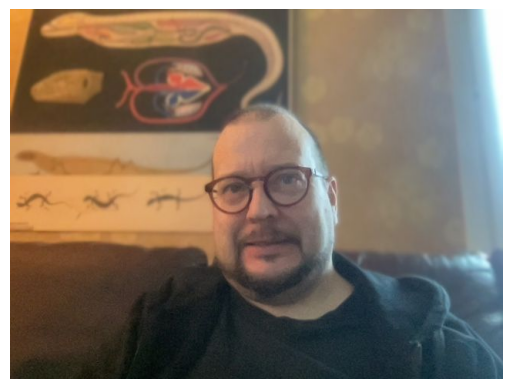

In [ ]:
from IPython.display import HTML, display
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            const video = document.createElement('video');
            const canvas = document.createElement('canvas');

            capture.textContent = "Take Photo";
            div.appendChild(video);
            div.appendChild(capture);

            video.style.display = 'block';
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => {
                capture.onclick = resolve;
            });

            const context = canvas.getContext('2d');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            context.drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')

    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = base64.b64decode(data.split(',')[1])

    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

try:
    filename = take_photo()
    print('Saved to', filename)

    # Näytä otettu kuva
    img = plt.imread(filename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except Exception as e:
    print('Error:', str(e))


In [ ]:
import io

def analyze_face(image_path):
    try:
        if not os.path.exists(image_path):
          return {"virhe": "Kuvatiedostoa ei löydy"}

        with open(image_path, 'rb') as image_file:
            image_data = image_file.read()
            if not image_data:
                return {"virhe": "Kuvatiedoston lukeminen epäonnistui"}

            detected_faces = face_client.face.detect_with_stream(
                io.BytesIO(image_data),
                detection_model='detection_03',
                recognition_model='recognition_04',
                return_face_attributes=['gender']
                #return_face_attributes=['age', 'gender', 'glasses', 'emotion']
            )

        if not detected_faces:
            return {"virhe": "Kasvoja ei löytynyt kuvasta"}

        # Otetaan ensimmäiset löydetyt kasvot
        face = detected_faces[0]

        # Kootaan tulokset
        results = {
            #"ikä": face.face_attributes.age,
            "sukupuoli": face.face_attributes.gender,
            #"silmälasit": face.face_attributes.glasses,
            #"tunnetila": max(face.face_attributes.emotion.__dict__.items(),
            #               key=lambda x: x[1])[0]
        }

        return results

    except Exception as e:
           if hasattr(e, 'response') and hasattr(e.response, 'text'):
               print(f"Lisätiedot: {e.response.text}")
           return {"virhe": f"Analyysi epäonnistui: {str(e)}"}

print("Analysointi-funktio luotu onnistuneesti!")

Analysointi-funktio luotu onnistuneesti!


In [ ]:
# Testataan koko prosessi
try:
    print("Otetaan kuva...")
    image_path = take_photo()

    # Varmistetaan, että kuva on tallennettu
    if not os.path.exists(image_path):
        raise Exception("Kuvaa ei löytynyt. Varmista, että kamera toimii oikein.")


    print("\nAnalysoidaan kuvaa...")
    results = analyze_face(image_path)

    print("\nTulokset:")
    for key, value in results.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Virhe tapahtui: {e}")
# Testataan koko prosessi
try:
    print("Otetaan kuva...")
    image_path = take_photo()

    # Varmistetaan, että kuva on tallennettu
    if not os.path.exists(image_path):
        raise Exception("Kuvaa ei löytynyt. Varmista, että kamera toimii oikein.")


    print("\nAnalysoidaan kuvaa...")
    results = analyze_face(image_path)

    print("\nTulokset:")
    for key, value in results.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Virhe tapahtui: {e}")
# Testataan koko prosessi
try:
    print("Otetaan kuva...")
    image_path = take_photo()

    # Varmistetaan, että kuva on tallennettu
    if not os.path.exists(image_path):
        raise Exception("Kuvaa ei löytynyt. Varmista, että kamera toimii oikein.")


    print("\nAnalysoidaan kuvaa...")
    results = analyze_face(image_path)

    print("\nTulokset:")
    for key, value in results.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Virhe tapahtui: {e}")
# Testataan koko prosessi
try:
    print("Otetaan kuva...")
    image_path = take_photo()

    # Varmistetaan, että kuva on tallennettu
    if not os.path.exists(image_path):
        raise Exception("Kuvaa ei löytynyt. Varmista, että kamera toimii oikein.")


    print("\nAnalysoidaan kuvaa...")
    results = analyze_face(image_path)

    print("\nTulokset:")
    for key, value in results.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Virhe tapahtui: {e}")
# Testataan koko prosessi
try:
    print("Otetaan kuva...")
    image_path = take_photo()

    # Varmistetaan, että kuva on tallennettu
    if not os.path.exists(image_path):
        raise Exception("Kuvaa ei löytynyt. Varmista, että kamera toimii oikein.")


    print("\nAnalysoidaan kuvaa...")
    results = analyze_face(image_path)

    print("\nTulokset:")
    for key, value in results.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Virhe tapahtui: {e}")
# Testataan koko prosessi
try:
    print("Otetaan kuva...")
    image_path = take_photo()

    # Varmistetaan, että kuva on tallennettu
    if not os.path.exists(image_path):
        raise Exception("Kuvaa ei löytynyt. Varmista, että kamera toimii oikein.")


    print("\nAnalysoidaan kuvaa...")
    results = analyze_face(image_path)

    print("\nTulokset:")
    for key, value in results.items():
        print(f"{key}: {value}")

except Exception as e:
    print(f"Virhe tapahtui: {e}")
    if hasattr(e, 'response') and hasattr(e.response, 'text'):
        print(f"Lisätiedot: {e.response.text}")
    # This line was causing a syntax error outside of a function definition.
    # You might want to place this inside a function or handle it appropriately.
    # return {"virhe": f"Analyysi epäonnistui: {str(e)}"}

Otetaan kuva...


<IPython.core.display.Javascript object>


Analysoidaan kuvaa...
Lisätiedot: {
  "error": {
    "code": "InvalidRequest",
    "message": "Invalid request has been sent.",
    "innererror": {
      "code": "UnsupportedFeature",
      "message": "Return Attributes (emotion, gender, age, smile, facial hair, hair and makeup) have been deprecated and are no longer supported. For more information, please see https://aka.ms/facerecognition."
    }
  }
}

Tulokset:
virhe: Analyysi epäonnistui: (InvalidRequest) Invalid request has been sent.
Otetaan kuva...


<IPython.core.display.Javascript object>

KeyboardInterrupt: 